# Tutorial: Credible Intervals/Regions

Here we'll compare different conventions for defining "best values" and credible intervals (CI's) to summarize posterior PDFs.

You will
* compare conventions that report the posterior mode and highest density region; median and quantiles of the posterior; and mean and standard deviation of the posterior (the latter being **highly discouraged**)
* compute the above from samples of a PDF rather than from an analytic function, since in the future samples are usually the only characterization of the posterior that we will have
* use these methods to produce credible _intervals_ (CI's) for a single parameter, and credible _regions_ (CR's) for 2 parameters

In principle, the calculations involved in doing these things are not difficult, but we also don't think they're terribly illuminating. On the other hand, you'll need to know how to produce CI's and CR's to summarize the results of pretty much every inference from now on. The upshot is that this tutorial resembles a walkthrough of particular software much more than most.

In [1]:
TutorialName = 'credible'
exec(open('tbc.py').read()) # define TBC and TBC_above
import numpy as np
import scipy.stats as st
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

First, we define two concrete test cases to work with. Per the goals for this notebook, these will not be in the form of posterior PDF _functions_, but rather lists of samples from posterior PDFs. (If you do find yourself wanting to compute CI's from a posterior function, you could always evaluate the function over a grid, and coerce those results into the form of the 1D or 2D histogram objects used below, then proceed in the same way.)

We'll find 1D "best values" and CI's for each of these, and afterward turn to the case of a joint CR for parameters $x$ and $y$, where `x=test1D_1` and `y=test1D_2`.

In [2]:
test1D_1 = st.beta.rvs(1.5, 5.0, size=100000)
test1D_2 = np.concatenate((st.norm.rvs(loc=-2.0, size=60000), st.norm.rvs(loc=2.0, size=40000)))

We'll see histograms of these samples below, but in brief `test1D_1` is a skewed but single-peaked distribution, while `test1D_2` is a bimodal mixture of 2 Gaussians.

We'll find intervals corresponding to "$1\sigma$" and "$2\sigma$" equivalent probability. Recall that these are $\approx$0.683 and 0.954, or more precisely:

In [3]:
st.chi2.cdf([1.0, 4.0], df=1)

array([0.68268949, 0.95449974])

## 1D intervals

Let's start with the 1D best value and CI for `test_1D_1`.

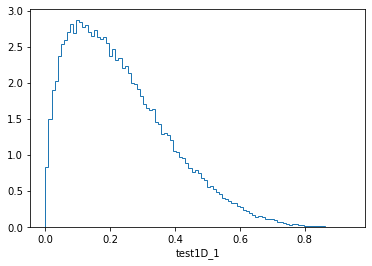

In [4]:
plt.hist(test1D_1, bins=100, density=True, histtype='step');
plt.xlabel('test1D_1');

First, we'll find the mode and highest posterior density CI's using the only package we know of that does the latter correctly.

In [5]:
import incredible as cr

With this package, there are actually two steps. The first converts the samples into a histogram, optionally doing some smoothing, and optionally accounting for non-uniform weights (a feature of some samplers we will see later). After that, there is a second function call to find the mode and CI's. This is so that the second function can also be used in cases where we have, e.g., direct evaluations of the posterior on a grid (we would just have to coerce those into the same format as the histogram that gets made from samples).

A simple call of the first function, `whist`, produces the following:

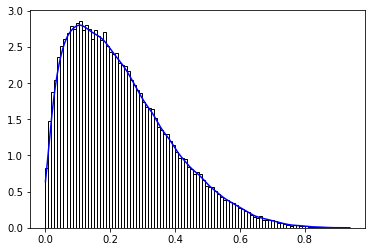

In [6]:
h1 = cr.whist(test1D_1, plot=plt)

Note that, by default, this function does some smoothing, specifically using a kernel density estimate method. This is why the blue curve (which is what is actually returned), is smoother than the raw histogram shown in the background. Note that the mode of the blue curve may not be identical to the $x$ value where the the raw histogram is highest. It's often true that the mode of an unsmoothed histogram will be thrown off by monte carlo noise (this is the reason for smoothing in the first place). In general, one should smooth until noisy features that you're pretty sure shouldn't be there are gone, and no more than that - assuming you're confident enough to make that call (if not, you may need to get more samples). Hence, this is a plot that one would want to look at with real eyeballs, if only briefly, to ensure that results based on the smoothed or unsmoothed histogram are reasonable.

There may be times when you want to not smooth, or to have finer control over the smoothing (e.g., if you believe the identified mode is still off due to remaining noise). See the docstring for details, but for example one could instead do no smoothing with a set number of bins

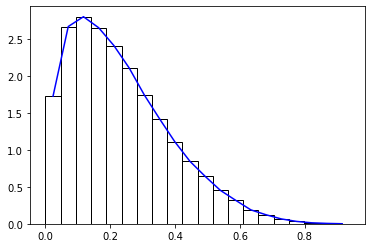

In [11]:
cr.whist(test1D_1, plot=plt, bins=20, smooth=False);

or smoothing on a fixed scale with more bins

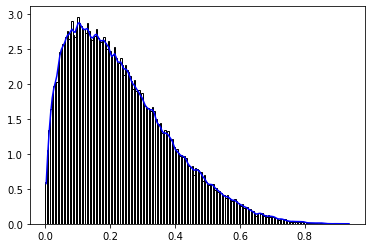

In [8]:
cr.whist(test1D_1, plot=plt, bins=200, smooth=1);

For reference, take a look at the returned object, a dictionary that straightforwardly holds the abscissae and estimated density of the PDF.

In [9]:
h1

{'x': array([7.31636370e-06, 1.84400224e-03, 3.68068811e-03, 5.51737399e-03,
        7.35405986e-03, 9.19074574e-03, 1.10274316e-02, 1.28641175e-02,
        1.47008034e-02, 1.65374892e-02, 1.83741751e-02, 2.02108610e-02,
        2.20475469e-02, 2.38842327e-02, 2.57209186e-02, 2.75576045e-02,
        2.93942904e-02, 3.12309762e-02, 3.30676621e-02, 3.49043480e-02,
        3.67410339e-02, 3.85777197e-02, 4.04144056e-02, 4.22510915e-02,
        4.40877773e-02, 4.59244632e-02, 4.77611491e-02, 4.95978350e-02,
        5.14345208e-02, 5.32712067e-02, 5.51078926e-02, 5.69445785e-02,
        5.87812643e-02, 6.06179502e-02, 6.24546361e-02, 6.42913220e-02,
        6.61280078e-02, 6.79646937e-02, 6.98013796e-02, 7.16380655e-02,
        7.34747513e-02, 7.53114372e-02, 7.71481231e-02, 7.89848090e-02,
        8.08214948e-02, 8.26581807e-02, 8.44948666e-02, 8.63315525e-02,
        8.81682383e-02, 9.00049242e-02, 9.18416101e-02, 9.36782960e-02,
        9.55149818e-02, 9.73516677e-02, 9.91883536e-02, 1.0

Next, assuming this looks reasonable (we'll use the first call to `whist` above), we feed the output into `whist_ci`:

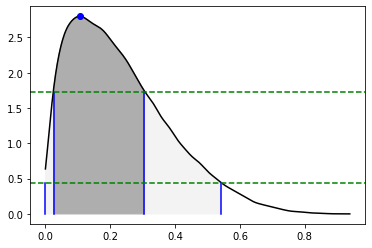

In [12]:
ci1 = cr.whist_ci(h1, plot=plt)

This plot should look familiar from the notes. It shows the mode and the 1 and 2 sigma intervals, whose bounding probabilities are indicated by the horizontal lines. Here you should look at the intersection of the blue/solid and green/dashed lines with the black/solid PDF - if they aren't all coming together in the same place, then the underlying histogram needs to be binned more finely. (Try this with the `bin=20` version above for comparison.)

The return value contains a number of useful (and some redundant) values. Of most interest are the `mode` and interval `min` and `max` values. `low` and `high` are just the distance of `min` and `max` from the mode. Finally, `center` is the average of `min` and `max`, and `width` is half the difference between `min` and `max`. These are convenient for cases where the CI is symmetric about the mode (at the precision we would be reporting them).

In [13]:
ci1

{'mode': 0.10653509707756191,
 'level': array([0.68268949, 0.95449974]),
 'prob': array([0.68468262, 0.9553121 ]),
 'density': array([1.73103911, 0.44307169]),
 'min': array([2.57209186e-02, 7.31636370e-06]),
 'max': array([0.30489717, 0.53999296]),
 'low': array([-0.08081418, -0.10652778]),
 'high': array([0.19836207, 0.43345787]),
 'center': array([0.16530905, 0.27000014]),
 'width': array([0.13958813, 0.26999282])}

For completeness, `level` contains the probability defining the interval that each entry belongs to, `prob` is the probability contained within each entry (these are identical when an interval is simply connected; we'll see the distinction below), and `density` is the height of the green lines in the figure above.

In text, we would normally report the constraint as $\mathrm{mode}^{+\mathrm{high}}_{-\mathrm{low}}$, or $\mathrm{center}\pm\mathrm{width}$ if the CI is symmetric.

Next, compute the alternative "best fit" and CI's using the median/quantiles method from the notes. Store the median as a scalar and the intervals as shape (2,) arrays holding the **endpoints** of each interval.

In [15]:
med1 = np.median(test1D_1)
quant1_1 = np.array([np.median(test1D_1)-np.std(test1D_1),
                    np.median(test1D_1)+np.std(test1D_1)])
quant1_2 = np.array([np.median(test1D_1)-2*np.std(test1D_1),
                    np.median(test1D_1)+2*np.std(test1D_1)])

print(med1, quant1_1, quant1_2)

0.2029336730722735 [0.04879492 0.35707242] [-0.10534383  0.51121117]


Even though their use is not recommended, we'll also compare to the mean/standard deviation. The naively defined 1 and 2 $\sigma$ intervals would be `mea1 +/- std1` and `mea1 +/- 2*std1`.

In [16]:
mea1 = np.mean(test1D_1)
std1 = np.std(test1D_1)
print(mea1, std1)

0.23124231377782112 0.15413875078337094


Here we'll show the 1 and 2 $\sigma$ median/quantile (orange) and mean/standard deviation (green) summaries over the plot from earlier (at arbitrary y-axis values). You can see that none of them quite agree with one another, and that the mean/standard deviation $2\sigma$ interval includes negative values where the PDF is zero!

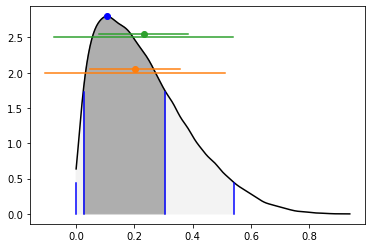

In [17]:
ci1 = cr.whist_ci(h1, plot=plt, plot_levels=False)
plt.plot(quant1_2, [2.,2.], color='C1')
plt.plot(quant1_1, [2.05,2.05], color='C1')
plt.plot(med1, 2.05, 'o', color='C1')
plt.plot(mea1, 2.55, 'o', color='C2')
plt.plot([mea1-std1, mea1+std1], [2.55,2.55], color='C2')
plt.plot([mea1-2*std1, mea1+2*std1], [2.5,2.5], color='C2');

Go through the same procedure for `test1D_2` next.

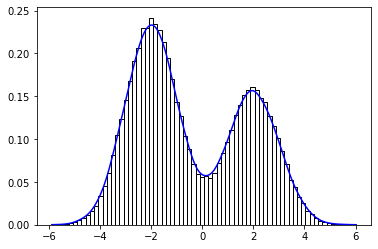

In [18]:
h2 = cr.whist(test1D_2, plot=plt)

In [20]:
med2 = np.median(test1D_2) 
quant2_1 = np.array([np.median(test1D_2)-np.std(test1D_2),
                    np.median(test1D_2)+np.std(test1D_2)])
quant2_2 = np.array([np.median(test1D_2)-2*np.std(test1D_2),
                    np.median(test1D_2)+2*np.std(test1D_2)])

print(med2, quant2_1, quant2_2)

-1.033421955406581 [-3.23261106  1.16576715] [-5.43180016  3.36495625]


In [21]:
mea2 = np.mean(test1D_2)
std2 = np.std(test1D_2)
print(mea2, std2)

-0.40335412888741057 2.19918910201856


{'mode': -1.9755536990896734,
 'level': array([0.68268949, 0.68268949, 0.95449974]),
 'prob': array([0.46105073, 0.22197956, 0.9548356 ]),
 'density': array([0.1168479 , 0.1168479 , 0.04601452]),
 'min': array([-3.21171701,  1.21981185, -3.84146059]),
 'max': array([-0.78603806,  2.75918503,  3.57551929]),
 'low': array([-1.23616331,  3.19536555, -1.86590689]),
 'high': array([1.18951564, 4.73473873, 5.55107299]),
 'center': array([-1.99887754,  1.98949844, -0.13297065]),
 'width': array([1.21283948, 0.76968659, 3.70848994])}

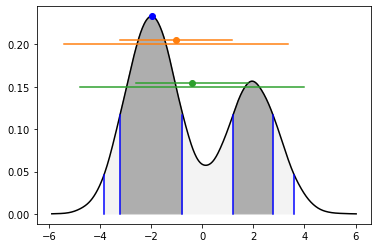

In [22]:
ci2 = cr.whist_ci(h2, plot=plt, plot_levels=False)
plt.plot(quant2_2, [0.2,0.2], color='C1')
plt.plot(quant2_1, [0.205,0.205], color='C1')
plt.plot(med2, 0.205, 'o', color='C1')
plt.plot(mea2, 0.155, 'o', color='C2')
plt.plot([mea2-std2, mea2+std2], [0.155,0.155], color='C2')
plt.plot([mea2-2*std2, mea2+2*std2], [0.15,0.15], color='C2')
ci2

Interesting... this is an example of a multimodal PDF where the $1\sigma$ highest-density CI is multiply connected (i.e. not contiguous). Note that `ci2` contains _two_ entries for `level` 0.683 to reflect this. The corresponding values in `prob` show the integrated probability in each of them, if that's useful.

How would one summarize the $1\sigma$ highest density CI in text? The short answer is: honestly, and that means using more characters than $x \pm \sigma_x$. One could simply say that the CI consists of two disjoint intervals, and what those intervals are. At the same time, the existeance of a multiply connected CI for one parameter suggests that there may be similar structure in the marginalized posteriors of other parameters, or pairs of parameters, so we'd want to carefully look at all of them to see if that's the case. And, of course, in a real situation this structure might actually tell us something interesting about the model that should be commented on.

## 2D regions

Next we have the case of 2D credible regions (CR's), where we'll take `test1D_1` and `test1D_2` to be samples of two parameters from the same model.

To find the HPD regions, we have analogous functions to the ones used above. However, `whist2d` does not have a KDE smoothing option, so in general you will want to manually adjust the number of bins (in each parameter) and the size of the smoothing kernel (in units of bins). For example, compare the following:

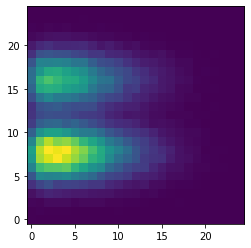

In [23]:
h3 = cr.whist2d(test1D_1, test1D_2, bins=25, smooth=0, plot=True)

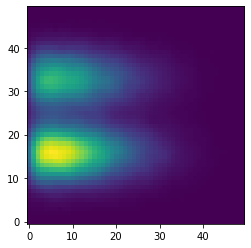

In [24]:
h3 = cr.whist2d(test1D_1, test1D_2, bins=50, smooth=1, plot=True)

The return value of this function is a dictionary with `x`, `y` and `z` entries, corresponding to the two parameter values at the bin centers, and the density in each bin. These have dimensionality 1, 1, and 2, respectively.

To find the CR's, we call `whist2d_ci`.

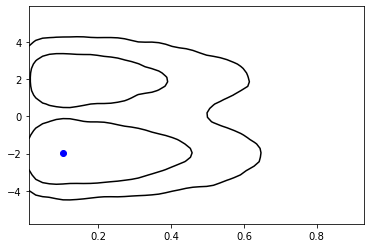

In [25]:
ci3 = cr.whist2d_ci(h3)

This returns the mode and the list of points making up the contours in the above plot in a slightly complicated structure that you can examine if you're interested.

One should test whether the amount of smoothing used is too much. (This is important in the 1D case also, but the KDE method is more likely to _undersmooth_.) Overlaying smoothed and less smoothed contours is a useful way of doing this.

/Users/jihwan/opt/anaconda3/lib/python3.8/site-packages/incredible/incredible.py:241: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plot = plt.axes()


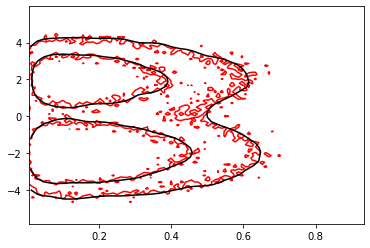

In [26]:
h3 = cr.whist2d(test1D_1, test1D_2, bins=100, smooth=0);
ci3 = cr.whist2d_ci(h3, mode_fmt=None, contour_color='r');
h3 = cr.whist2d(test1D_1, test1D_2, bins=50, smooth=1);
ci3 = cr.whist2d_ci(h3, mode_fmt=None);

In this comparison, the more smoothed contours should look like... a smoothed version of the squiggly ones, as opposed to being much broader.

Note that the function that extracts the contours in `whist2d_ci` (distinct from the one that _plots_ them) is not foolproof - it seems especially likely to screw up if there are too many complicated squiggles. So it is (a) extra-important to do this check, and (b) best to use `whist2d` for the check rather than the function (below) that simply plots contours once you've found them. Once you know what the contours are supposed to look like, you can make sure nothing pathalogical has happened when they get re-plotted (as below). If you do find yourself looking at weirdly blocky contours when using `ci2D_plot`, when everything looked fine with `whist2d_ci`, there isn't currently a great solution; however, the pathology seems to be rare enough that e.g. throwing away a few samples might be enough to avoid it.

There is no 2D analog of the median/quantile convention for CI's, but we can compare with the equivalent (still not recommended) regions defined via the parameter means and covariance.

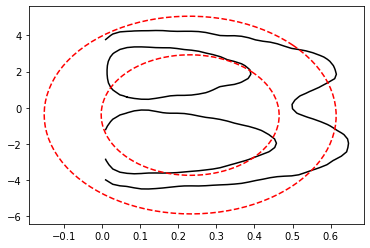

In [27]:
cr.ci2D_plot(ci3['contours'][1], plt) # this is how you plot contours from whist2d_ci without having to
cr.ci2D_plot(ci3['contours'][0], plt) # repeat all the calculations

cv = np.cov(test1D_1, test1D_2)
cr.cov_ellipse(cv, center=[mea1,mea2], level=0.68268949, plot=plt, fmt='r--');
cr.cov_ellipse(cv, center=[mea1,mea2], level=0.95449974, plot=plt, fmt='r--');

Note that the stand-alone contour plotting function `ci2D_plot`, adds a single contour level at a time, so it was called twice.

Options to the various lower-level `matplotlib` functions that are called can be used to customize things, e.g.:

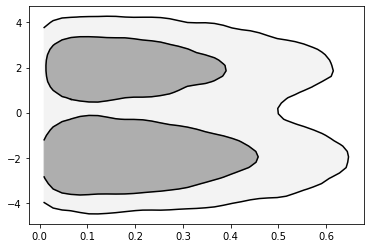

In [28]:
cr.ci2D_plot(ci3['contours'][1], plt, fill=True, fill_kwargs={'color':str(0.954)})
cr.ci2D_plot(ci3['contours'][0], plt, fill=True, fill_kwargs={'color':str(0.683)})

An increasingly common way to visualize multiple 1D and 2D marginalized PDFs from a high-dimensional posterior distribution is the so-called "triangle plot" that has the 1D PDFs on its diagonal and each corresponding 2D PDF off the diagonal, in a triangular matrix of plots. For example, this call finds all of the CI's and CR's (note that it has to pop up a contour plot due to the way `whist2d_ci` works internally).

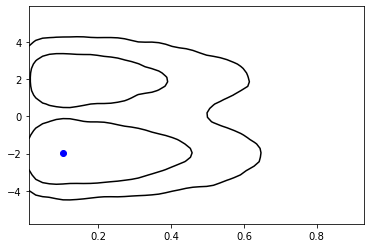

In [29]:
tri = cr.whist_triangle(np.array([test1D_1, test1D_2]).T, bins=50, smooth2D=1)

We can display the triangle thusly:

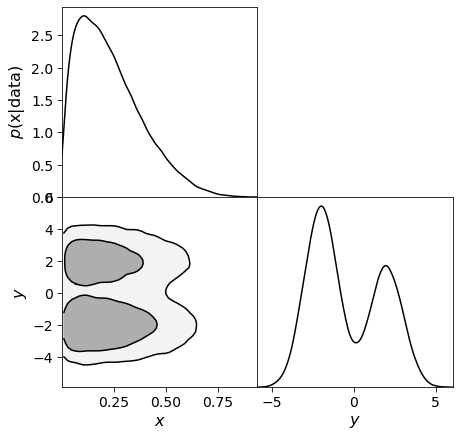

In [30]:
cr.whist_triangle_plot(tri, paramNames=[r'$x$', r'$y$']);

Again, lots of options can be customized, and other things can be added to any of the panels via the returned array of `matplotlib` axes. For example,

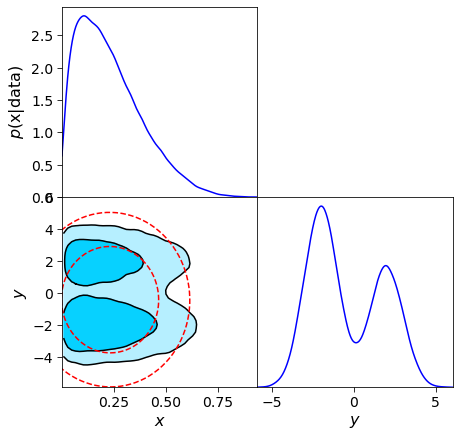

In [31]:
f, a = cr.whist_triangle_plot(tri, paramNames=[r'$x$', r'$y$'], linecolor1D='b',
                              fillcolors2D=[(0.026, 0.818, 1.000), (0.714, 0.936, 1.000)]);
cr.cov_ellipse(cv, center=[mea1,mea2], level=0.68268949, plot=a[1][0], fmt='r--');
cr.cov_ellipse(cv, center=[mea1,mea2], level=0.95449974, plot=a[1][0], fmt='r--');

### Alternative packages

There are other packages that can be better for getting a quick look at plots like those above, in particular `corner` and `pygtc`. We'll use both of these in later tutorials. They have the advantage that you get the whole triangle plot from a single function call. The downside is that all the calculations are redone each time you call the function, and it isn't so straightforward to do the sanity checks mentioned above. So we recommend using one of those packages only for quickly visualizing samples from a PDF. In contrast, with `incredible` it's straightforward to do the hard calculations once, and then tweak the display to your heart's content, so it might be more suitable for publication graphics (in addition to providing the CI calculations). To summarize the options as of this writing:
* `pygtc`: looks nicer than `corner`; can put multiple posteriors on the same plot
* `corner`: arguably a little easier to use than `pygtc`, but uglier; downgraded because the default 2D probability levels shown are not the conventional ones
* `incredible`: provides fine-tuned control over CR calculations, and ability to save results rather than just a plot, but needs some hand holding